<a href="https://colab.research.google.com/github/allokeen/ML_Colorizing/blob/main/Convolutional_Colorizing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import google.colab
google.colab.drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
import cv2
import os

In [ ]:
def load_image_for_model(file_path):
    img = load_img(file_path)
    img = img_to_array(img).astype(np.uint8)
    img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    return img_lab

def to_LAB_arrays(path_to_imgs):
    L_channel = []
    AB_channels = []
    for path in path_to_imgs:
        img_lab = load_image_for_model(path)
        L_channel.append(img_lab[:, :, 0]/255)
        AB_channels.append(img_lab[:, :, 1:]/255)
    L_channel = np.array(L_channel).reshape(-1, 256, 256, 1)
    AB_channels = np.array(AB_channels).reshape(-1, 256, 256, 2)
    return L_channel, AB_channels


In [ ]:
def build_model():
    model = Sequential()
    model.add(InputLayer(input_shape=(256, 256, 1)))

    # Convolutional layers
    # ADDED: He initialization, BatchNorm, and Dropout
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2, kernel_initializer=HeNormal(), kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))  # 128x128

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2, kernel_initializer=HeNormal(), kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))  # 64x64

    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2, kernel_initializer=HeNormal(), kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))  # 32x32

    # Decoding layers
    # ADDED: He initialization, BatchNorm, and Dropout
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2DTranspose(256, (3, 3), activation='relu', padding='same', strides=2, kernel_initializer=HeNormal(), kernel_regularizer=l2(0.01)))  # 64x64
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=2, kernel_initializer=HeNormal(), kernel_regularizer=l2(0.01)))  # 128x128
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=2, kernel_initializer=HeNormal(), kernel_regularizer=l2(0.01)))  # 256x256
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    # Final layer with sigmoid activation
    model.add(Conv2D(2, (3, 3), activation='sigmoid', padding='same'))

    model.compile(optimizer=Adam(), loss=MeanSquaredError())
    return model

# Learning phase

In [ ]:
# Preprocessing
img_paths = [os.path.join('/content/drive/My Drive/Colab Notebooks/ml-dataset-256x256/', fname) for fname in os.listdir('/content/drive/My Drive/Colab Notebooks/ml-dataset-256x256')]
L_arr, AB_arr = to_LAB_arrays(img_paths)


In [ ]:
# Building and training
model = build_model()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

checkpoint_path = "model_checkpoints/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Creating callbacks to save model
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1,
    period=1  # saving every epoch
)

model.fit(L_arr, AB_arr, epochs=00, batch_size=16, validation_split=0.1, callbacks=[cp_callback, early_stopping])
model.save('saved_model/my_model')

# Tesing

1/1 [==============================] - 0s 23ms/step


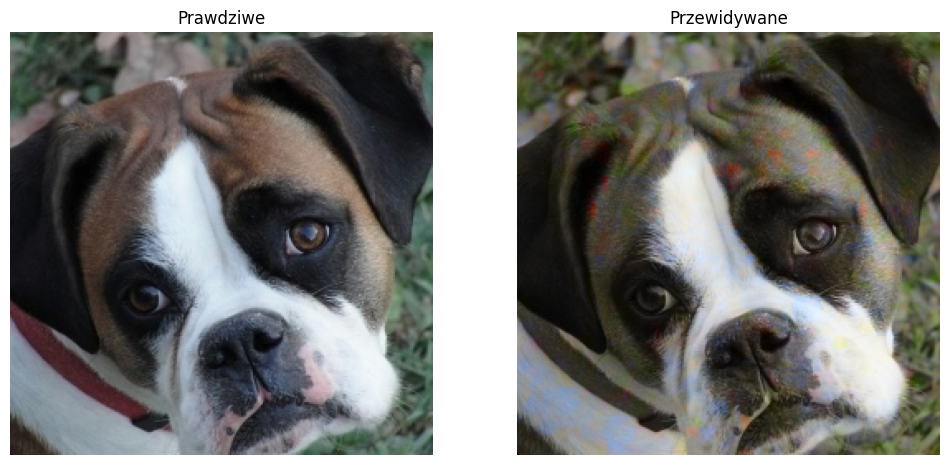

In [ ]:

#test_img_paths = [os.path.join('/content/drive/My Drive/Colab Notebooks/ml-dataset-256x256/', fname) for fname in os.listdir('/content/drive/My Drive/Colab Notebooks/ml-dataset-256x256')]
test_img_paths = ['/content/drive/My Drive/Colab Notebooks/ml-dataset-256x256/dog (309).jpg']
#test_img_paths = ['/content/drive/My Drive/Colab Notebooks/test/test2.png']
L_test, AB_test_true = to_LAB_arrays(test_img_paths)
AB_test_pred = model.predict(L_test)
#print(AB_test_true[:,:,0])
#print(AB_test_true[:,:,1])
#print(AB_test_pred[:,:,1])

import matplotlib.pyplot as plt

def plot_results(L, AB_true, AB_pred, index=0):
    """
    Funkcja do wyświetlenia wyników predykcji.
    """
    # Skala wartości LAB z powrotem do zakresu [0, 255]
    L = (L[index] * 255).astype(np.uint8)
    AB_true = (AB_true[index] * 255).astype(np.uint8)  # Skala AB z powrotem do zakresu [-128, 128]
    AB_pred = (AB_pred[index] * 255).astype(np.uint8)

    # Połączenie LAB i konwersja do RGB
    img_true = cv2.merge((L, AB_true[:, :, 0], AB_true[:, :, 1]))
    img_true = cv2.cvtColor(img_true, cv2.COLOR_LAB2RGB)

    img_pred = cv2.merge((L, AB_pred[:, :, 0], AB_pred[:, :, 1]))
    img_pred = cv2.cvtColor(img_pred, cv2.COLOR_LAB2RGB)

    # Wyświetlenie obrazów i modlitwa o dobry wynik
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(img_true)
    axs[0].set_title('Prawdziwe')
    axs[0].axis('off')

    axs[1].imshow(img_pred)
    axs[1].set_title('Przewidywane')
    axs[1].axis('off')

    plt.show()

# Wyświetl obraz
plot_results(L_test, AB_test_true, AB_test_pred, index=0)